# Overview:
Our goal is to answer some basic questions about the movie industry and make recommendations based on our findings. 

### Business Problem

Our client, Microsoft is planning to launch a new movie studio. We are to perfom market research and use our findings to recommend business practices that could reproduce the success of the biggest movies in the box office in recent history.

### Our Approach

First, we set out to learn a few basic things from our data- budgets, gross and net profit, which will inform our choices. 

Next, we examine various factors and look for correlations between them and profit. The factors we focused on most are genre, release date, run time and rating.

By isolating the factors that had the most positive correlation to profit, we are able to combine them and look for the most likely scenarios to generate returns, and how much to weigh each of our recommendations.

### Our Hypotheses

1. There is an optimum season to release movies, and we can break that down to month.
1. Some genres of movies are inherently more profitable than others. We can find out which, and use our findings to recommend content creation.
1. Budget is a predictor of which movies are most profitable. We can isolate a production budget window that is more likely to produce a good return.
1. Ratings are a driver for reviews, attention, press and word of mouth. We believe we can find a correlation between ratings and profitability, and if so, use that correlation to further explore the factors of a highly rated film using our other metrics.

### Importing Libraries and datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import requests
import sys
import time
from bs4 import BeautifulSoup
import data_func as func
import scrape

In [2]:
name_basics = pd.read_csv('../Data/imdb.name.basics.csv.gz')
title_akas = pd.read_csv('../Data/imdb.title.akas.csv.gz')
title_basics = pd.read_csv('../Data/imdb.title.basics.csv.gz')
title_ratings = pd.read_csv('../Data/imdb.title.ratings.csv.gz')
movie_info= pd.read_csv('../Data/rt.movie_info.tsv.gz', sep='\t')
rt_reviews= pd.read_csv('../Data/rt.reviews.tsv.gz', sep='\t', encoding='windows-1254')
budgets = pd.read_csv('../Data/tn.movie_budgets.csv.gz')
freshrating = pd.read_csv('../Data/freshrating.csv')

### Data cleaning, ordering and merging the datasets

Working with the budgets dataset- the most complete of our sheets at a glance, but missing values are represented as 0, so on a closer look we had to drop a lot of incomplete rows.

In [3]:
# converting all the money columns to ints and removing $

budgets.worldwide_gross = func.money_to_int(budgets.worldwide_gross)

budgets.domestic_gross = func.money_to_int(budgets.domestic_gross)

budgets.production_budget = func.money_to_int(budgets.production_budget)


# converting dates to datetime

budgets.release_date = func.col_datetime(budgets.release_date)


In [4]:
# creating columns for net and ROI

budgets['worldwide_net'] = func.calculate_net(budgets.worldwide_gross, budgets.production_budget)

budgets['profit_percentage'] = func.calculate_roi(budgets.worldwide_net, budgets.production_budget)


# renaming title column for a future merge

budgets.rename(columns= {'movie': 'primary_title'}, inplace= True)


# removing rows with release dates before 2000

budgets = func.release_window(budgets, 'release_date')


# dropping the zero value rows

budgets = budgets[budgets['domestic_gross']!=0]
budgets = budgets[budgets['worldwide_gross']!=0]

We merged the two IMDb sheets that seemed the most relevant to our questions, which allowed us to pull genre, rating and title information. 

In [5]:
# merging the sheets, dropping NaN values and seperating genres into lists

titlerate = title_ratings.merge(title_basics, on= 'tconst')

titlerate.dropna(subset= ['averagerating'], inplace = True)

titlerate.dropna(subset = ['genres'], inplace = True)

titlerate.genres = func.genre_convert(titlerate.genres)

The movie_info Rotten Tomatoes dataset proved far more useful than the wildly incomplete rt_reviews - since it includes revenue, dates, and genres. Unfortunately it does not include titles, which forced us to use it independently.

In [6]:
# converting dates to datetime, removing old movies and dropping the dvd date column

movie_info['theater_date'] = func.col_datetime(movie_info['theater_date'])

movie_info[~movie_info['theater_date'].isin(pd.date_range(start='1915-01-01', end= '1999-12-31'))]

movie_info.drop(['dvd_date'], axis = 1, inplace = True)

movie_info['box_office'] = movie_info['box_office'].str.replace(',','')

In [7]:
#splitting the genres in movie info

movie_info['genres']=movie_info.genre.apply(lambda x: re.split("and|\|",x) if isinstance(x,str) else x)


#dropping NAs from genres

movie_info.dropna(subset = ['genres'], inplace = True)

Finally, we merged the IMDb and budgets datasets to produce our most comprehensive sheet.

In [8]:
# merging the cleaned dataframes
maindf = budgets.merge(titlerate, on= 'primary_title', how= 'inner')

### Web Scraping

Because the Rotten Tomatoes datasets didn't include titles, we decided to scrape data from the internet and apply the ratings to the merged IMDb and budget tables- yeilding the most complete possible merge of the groups.

First we create a series of properly formatted titles to feed into the scrape function.

In [9]:
# reformatting the title column to be inserted into a url

title_series = maindf.original_title.str.replace(' ', '_')

Then we run the function and save the output to csv.

In [10]:
# # this is commented out to avoid a long wait while the scrape function renders

# fresh_scores = scrape.scrape(title_series)

# # converting the returned dictionary to a series

# fresh_scores = pd.Series(fresh_scores)

# # converting the titles back to the format in maindf

# fresh_scores.primary_title = test.primary_title.str.replace('_', ' ')

# # saving as a csv file

# fresh_scores.to_csv('./freshrating.csv')

In [10]:
#now we can merge the datasets into a new df- though smaller, it's now the most comprehensive set 

df = maindf.merge(freshrating, on= 'primary_title', how = 'inner')

df.rating = df.rating.str.replace('%', '')

df.rating = df.rating.astype(int)

### Visualizations and Examining the Datasets

#### Part 1: Ratings vs. Gross and Profit

There is a slight correlation between rating and gross.

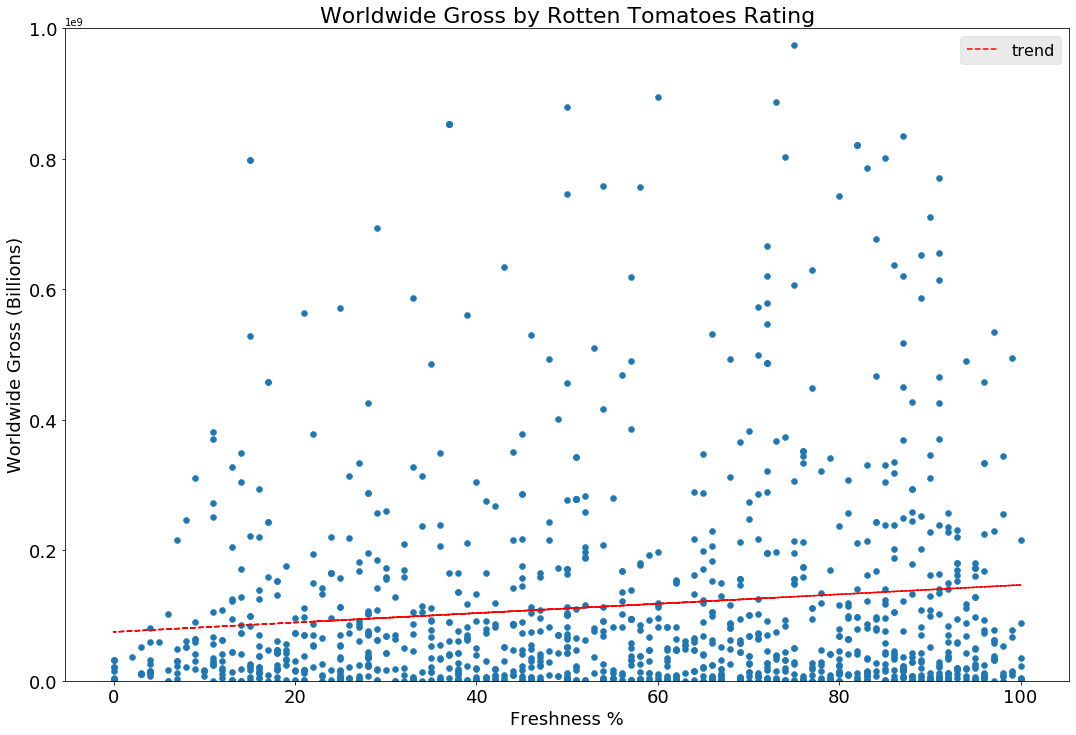

In [11]:
fig, ax = plt.subplots(figsize= (18, 12))

plt.style.use('ggplot')

x= df.rating
y= df.worldwide_gross 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

ax.set_xlabel('Freshness %', fontsize=18)
ax.set_ylabel('Worldwide Gross (Billions)', fontsize= 18)
ax.set_title('Worldwide Gross by Rotten Tomatoes Rating', fontsize= 22)

trend = plt.plot(x,p(x),"r--", label='trend')
plt.scatter(x, y)

ax.set_ylim(0, 1000000000)
ax.tick_params(labelsize= 18)
plt.legend(loc='upper right', handles = trend, fontsize= 16)

In [12]:
df.profit_percentage.corr(df.worldwide_gross)

0.10117710850610633

Profitability based on rating has a near zero correlation, on the other hand.

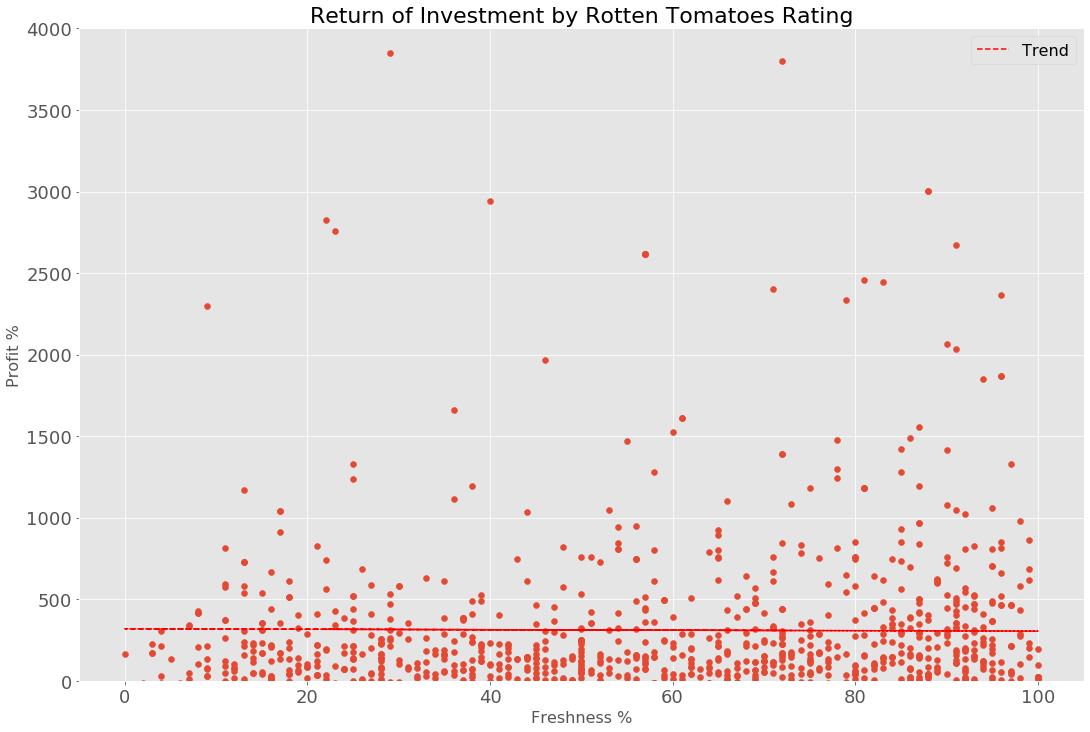

In [13]:
fig, ax = plt.subplots(figsize= (18, 12))

plt.style.use('ggplot')

x= df.rating
y= df.profit_percentage 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

ax.set_title('Return of Investment by Rotten Tomatoes Rating', fontsize=22)
ax.set_xlabel('Freshness %', fontsize= 16)
ax.set_ylabel('Profit %', fontsize= 16)

plt.scatter(x, y)
trend = plt.plot(x,p(x),"r--", label = 'Trend')

ax.set_ylim(0, 4000)
ax.tick_params(labelsize= 18)
plt.legend(loc= 'upper right', handles = trend, fontsize = 16)

In [14]:
df.profit_percentage.corr(df.rating)

-0.0029625973884967152

#### Part 2: Release Date vs. Gross and Profit

First we plotted the International Gross for our selected time period. There are some pretty obvious peaks and valleys, but we still need to get year over year data to see the trends.  

/Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<BarContainer object of 2200 artists>

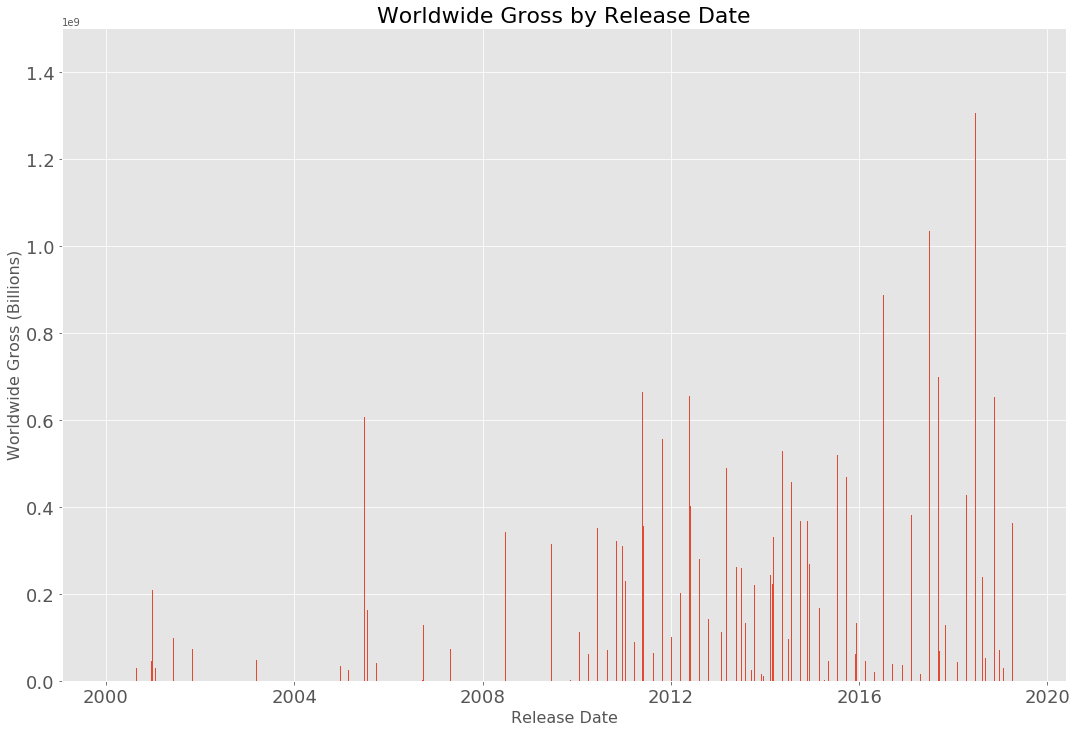

In [15]:

fig1, ax1 = plt.subplots(figsize= (18, 12))

x= maindf['release_date']
y= maindf.worldwide_gross 

ax1.set_xlabel('Release Date', fontsize= 16)
ax1.set_ylabel('Worldwide Gross (Billions)', fontsize = 16)
ax1.set_title('Worldwide Gross by Release Date', fontsize=22)

ax1.tick_params(labelsize= 18)
ax1.set_ylim(0, 1500000000)

plt.bar(x, y)

In [16]:
#calculating monthly average profit percentage to see which month is most profitable
maindf_monthnet = maindf.groupby(maindf['release_date'].dt.strftime('%m%B'))['profit_percentage'].mean().sort_index()

Next we plotted monthly averages. We can see there are some definite peak months- January, April, July and October

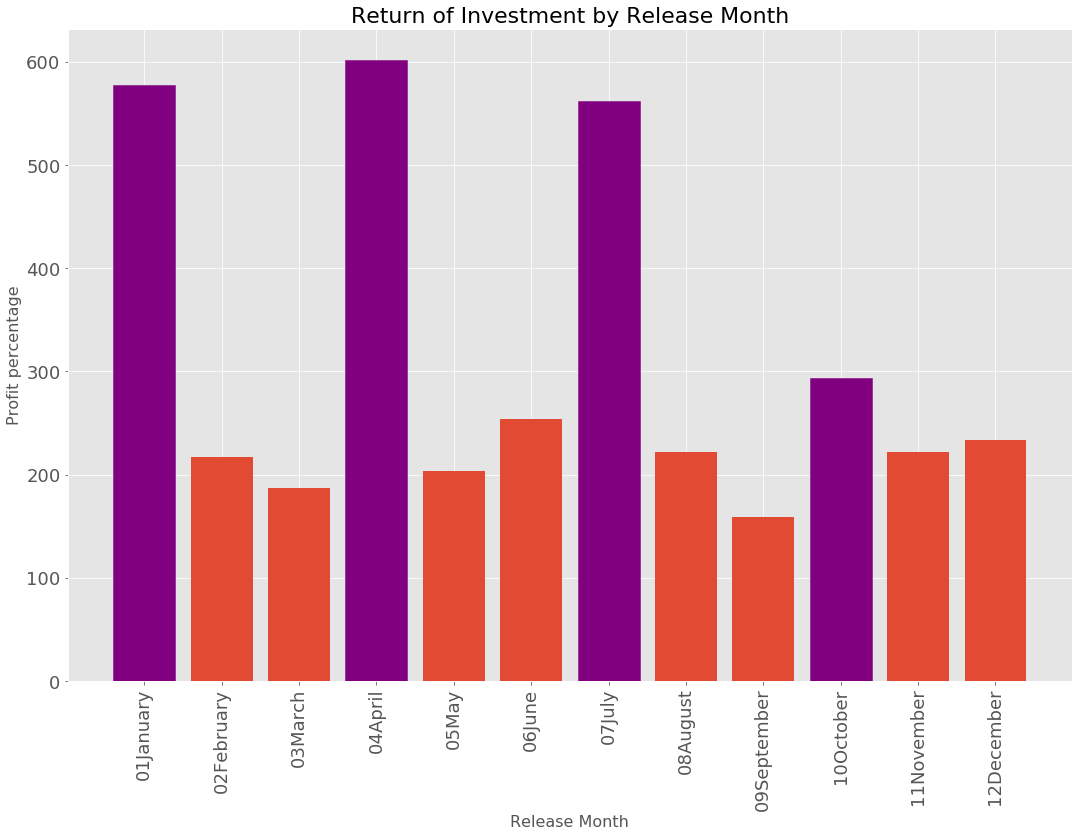

In [17]:
fig, ax = plt.subplots(figsize= (18, 12))
plt.style.use('ggplot')
x= maindf_monthnet.keys()
y= maindf_monthnet

ax.set_xlabel('Release Month', fontsize = 16)
ax.set_ylabel('Profit percentage', fontsize = 16)
ax.set_title('Return of Investment by Release Month', fontsize=22)

plt.xticks(rotation= 90)
ax.tick_params(labelsize= 18)

barplot = plt.bar(x,y)
barplot[0].set_color('purple')
barplot[3].set_color('purple')
barplot[6].set_color('purple')
barplot[9].set_color('purple');

#### Part 3: Runtime vs. Profit

We plotted runtime vs profit percentage to see if there's an ideal movie length, overall looks like there a very small negative correlation.

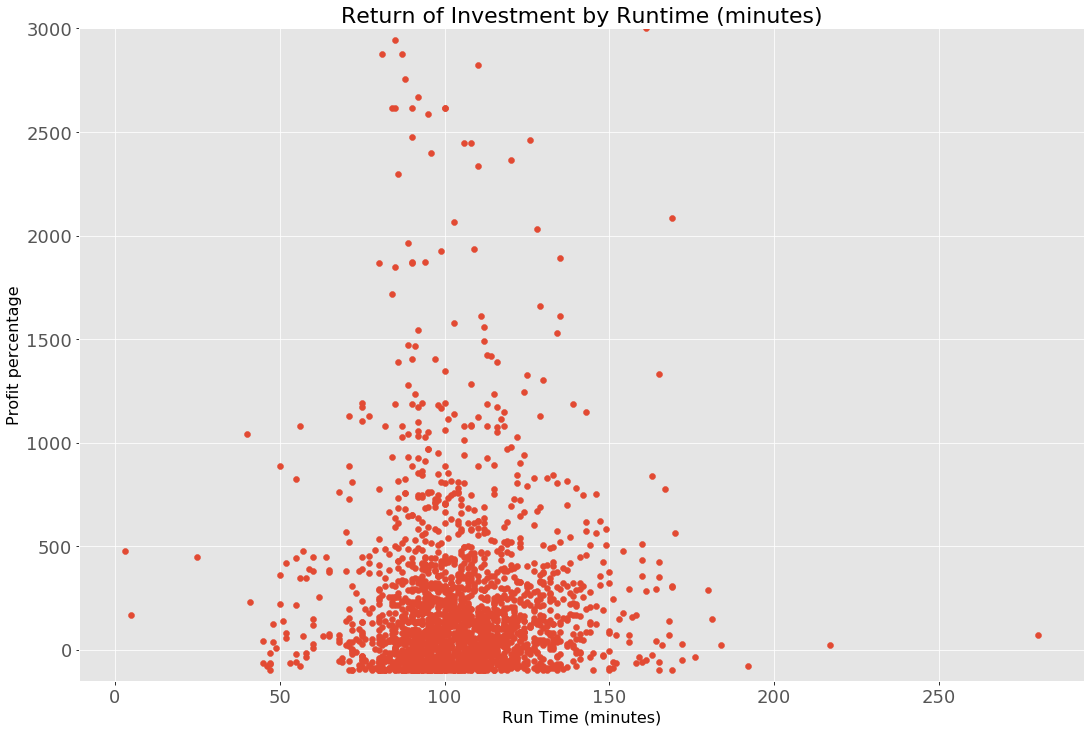

In [18]:
fig, ax = plt.subplots(figsize= (18, 12))

x= maindf['runtime_minutes']
y= maindf.profit_percentage

ax.set_xlabel('Run Time (minutes)', fontsize = 16, color= 'black')
ax.set_ylabel('Profit percentage', fontsize = 16, color= 'black')
ax.set_title('Return of Investment by Runtime (minutes)', fontsize = 22, color= 'black')
fig.patch.set_facecolor('white')

ax.set_ylim(-150, 3000)
ax.tick_params(labelsize= 18, color= 'black')
plt.scatter(x,y)


In [19]:
maindf.profit_percentage.corr(maindf['runtime_minutes'])

-0.03671530639198371

#### Part 4: Budget vs. Profit

In spite of a pretty strong correlation between budget and gross, there is a slight negative correlation between initial production budget and profitability, but there are a lot of outliers in our dataset, so we worked on a succession of graphs to show the removal of outlier data.

In [20]:
maindf.profit_percentage.corr(maindf['production_budget'])

-0.06475117822959285

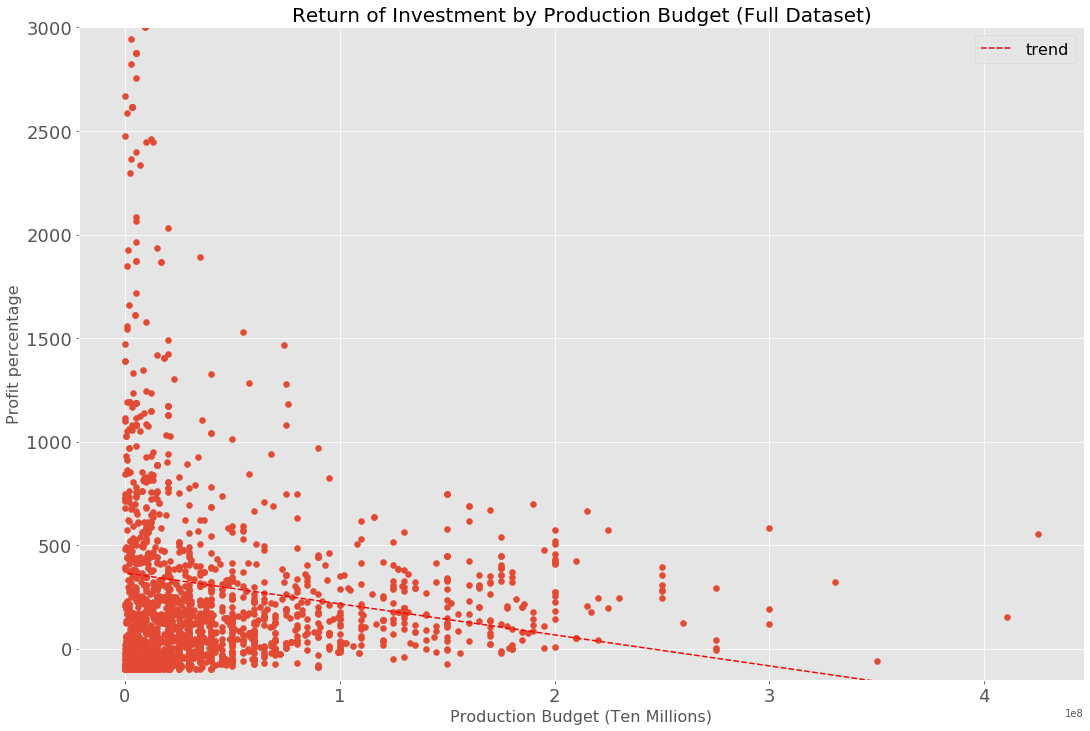

In [22]:
#plotting production budget vs. profit percentage to find ideal sweet spot of budget spent vs profit returned
fig, ax = plt.subplots(figsize= (18, 12))

x= maindf['production_budget']
y= maindf.profit_percentage
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

ax.set_title('Return of Investment by Production Budget (Full Dataset)', fontsize = 20)
ax.set_xlabel('Production Budget (Ten Millions)', fontsize = 16)
ax.set_ylabel('Profit percentage', fontsize = 16)

plt.scatter(x,y)
trend = plt.plot(x,p(x),"r--", label = 'trend')

ax.set_ylim(-150, 3000)
ax.tick_params(labelsize= 18)
plt.legend(loc= 'upper right', handles = trend, fontsize = 16);

We created two new datasets which successively cut the outlying data in order to find a window in which the likelihood of loss of profit was smaller or even reversed.

In [23]:
#creating copies of our maindf cleared out outlier data and with ~70% of central weighted data for the budget column
maindf_1 = pd.DataFrame(maindf)
maindf_1['production_budget'] = maindf_1['production_budget'].sort_values()[150:2500]
maindf_1.dropna(subset= ['production_budget'], inplace = True)

maindf_2 = pd.DataFrame(maindf)
maindf_2['production_budget'] = maindf_2['production_budget'].sort_values()[600:2100]
maindf_2.dropna(subset = ['production_budget'], inplace = True)

By clearing the outlier data successively we see the trend line flattening, and even starting to turn positive. Our conclusion is that by spending between 12 and $425 million in initial budget, we can signigicantly reduce the likelihood of running a loss percentage.

Text(0, 0.5, 'Profit percentage')

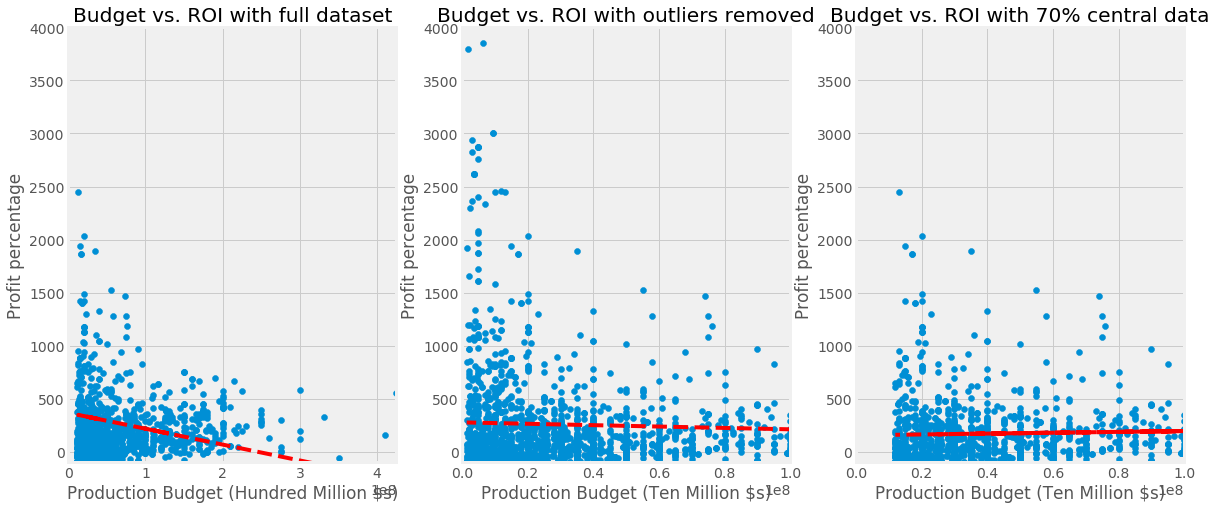

In [24]:
budget_fig = plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
ax = budget_fig.add_subplot(131)
ax1 = budget_fig.add_subplot(132)
ax2 = budget_fig.add_subplot(133)

# z = np.polyfit(maindf.production_budget, maindf.profit_percentage, 1)
z1= np.polyfit(maindf_1.production_budget, maindf_1.profit_percentage, 1)
z2= np.polyfit(maindf_2.production_budget, maindf_2.profit_percentage, 1)
p = np.poly1d(z)
p1 = np.poly1d(z1)
p2 = np.poly1d(z2)

ax.scatter(maindf.production_budget, maindf.profit_percentage)
ax.plot(maindf.production_budget, p(maindf.production_budget),"r--")

ax1.scatter(maindf_1.production_budget, maindf_1.profit_percentage)
ax1.plot(maindf_1.production_budget, p1(maindf_1.production_budget),"r--")

ax2.scatter(maindf_2.production_budget, maindf_2.profit_percentage)
ax2.plot(maindf_2.production_budget, p2(maindf_2.production_budget),"r--")

ax.set_ylim(-100, 4000)
ax1.set_ylim(-100, 4000)
ax2.set_ylim(-100, 4000)
ax.set_xlim(0, 425000000)
ax1.set_xlim(0, 100000000)
ax2.set_xlim(0, 100000000)

ax.set_title('Budget vs. ROI with full dataset')
ax1.set_title('Budget vs. ROI with outliers removed')
ax2.set_title('Budget vs. ROI with 70% central data')

ax.set_xlabel('Production Budget (Hundred Million $s)')
ax.set_ylabel('Profit percentage')
ax1.set_xlabel('Production Budget (Ten Million $s)')
ax1.set_ylabel('Profit percentage')
ax2.set_xlabel('Production Budget (Ten Million $s)')
ax2.set_ylabel('Profit percentage')

After clearing the outlying data we have an 8% correlation between budget and profit.

In [25]:
maindf_2.profit_percentage.corr(maindf_2.production_budget)

0.08178139798209115

#### Part 5- Genre vs. Profit and Rating

First off we check the average Return of Investment based on our top 10 genre groups.

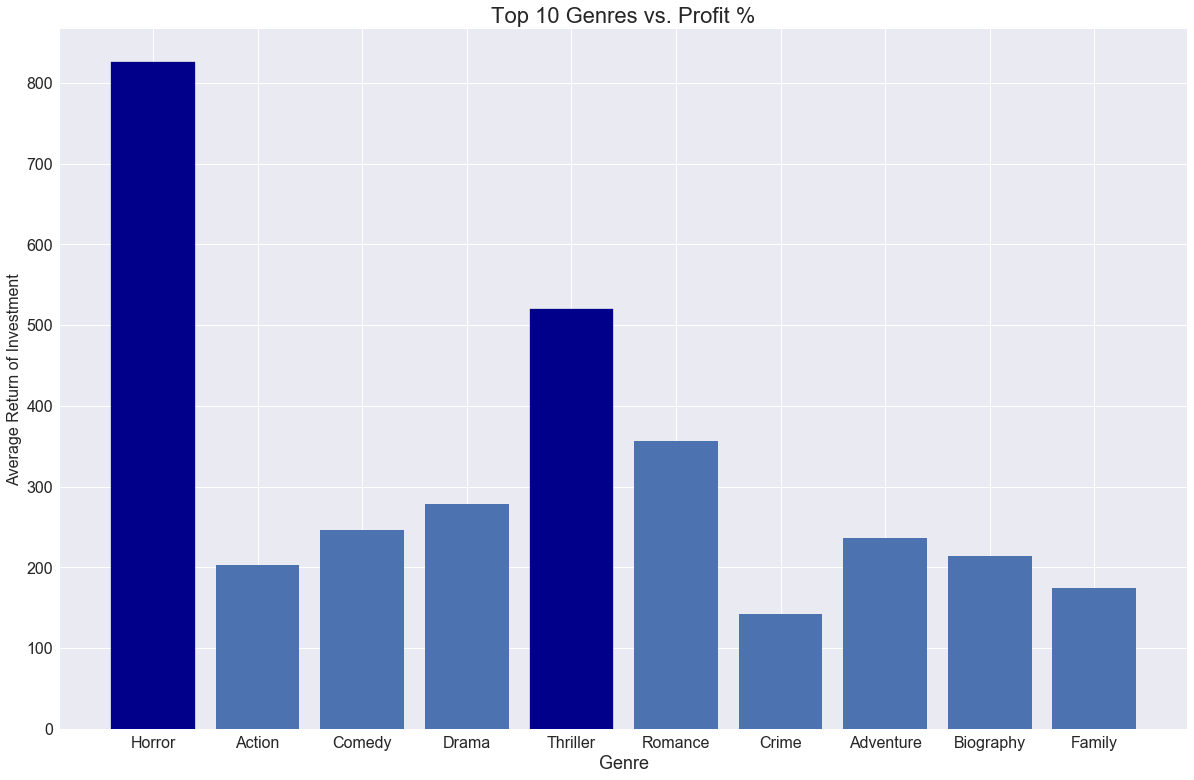

In [26]:
# The list of genres we want to iterate through and graph

list_of_genres = ['Horror', 'Action', 'Comedy', 'Drama', 'Thriller', 'Romance', 'Crime', 'Adventure', 'Biography', 'Family']

# Seperating by genre and creating a dictionary of average ROI, then converting to a series

genredf = func.create_genre_columns(maindf, maindf['genres'], list_of_genres)

gen_series = pd.Series(func.find_genre_profits(genredf, list_of_genres))


#Charting Genre vs. Profit % to see which Genre is most profitable
plt.style.use('seaborn')
X = list(gen_series.index)
Y = gen_series
fig, ax = plt.subplots(figsize=(18,12))
barplot = plt.bar(X, Y)
barplot[0].set_color('darkblue')
barplot[4].set_color('darkblue')
ax.set_title("Top 10 Genres vs. Profit %", fontsize=22) 
ax.set_xlabel('Genre', fontsize = 18)
ax.set_ylabel('Average Return of Investment', fontsize = 16)
ax.tick_params(labelsize= 16)
plt.show()

Since Horror seems to be by far the most profitable, followed by Thriller, we have some pretty solid conclusions about what kinds of movies to produce.

Next, we'll check genre against the average of the ratings we pulled from the Rotten Tomatoes site.

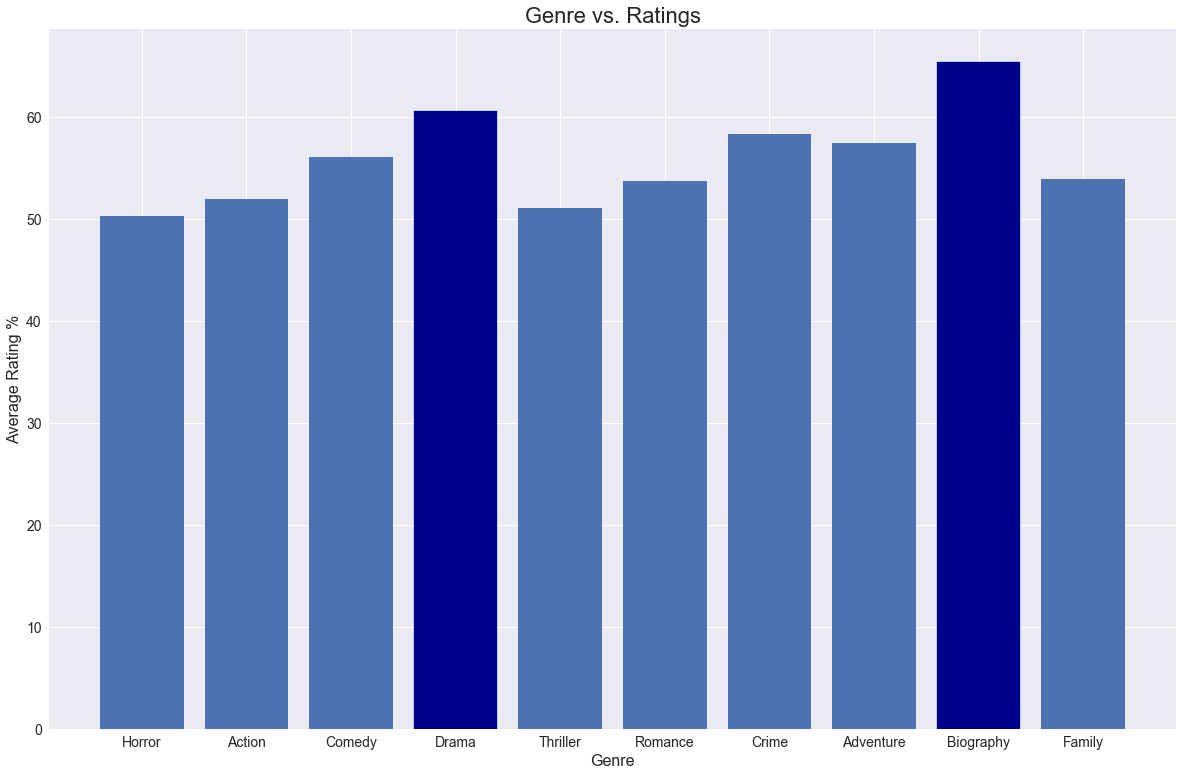

In [27]:
#Charting Genre vs. Rating to see which Genre receives highest ratings


rtgendf = func.create_genre_columns(df, df.genres, list_of_genres)
genrate = pd.Series(func.find_genre_ratings(rtgendf, list_of_genres))

X = list(genrate.index)
Y = genrate
fig, ax = plt.subplots(figsize=(18,12))
barplot = plt.bar(X, Y)
plt.style.use('seaborn')
barplot[3].set_color('darkblue')
barplot[8].set_color('darkblue')
ax.set_title("Genre vs. Ratings", fontsize = 22) 
ax.set_xlabel('Genre', fontsize = 16)
ax.set_ylabel('Average Rating %', fontsize = 16)
ax.tick_params(labelsize= 14)
plt.show()

Horror does seem to generate the lowest average ratings of all the genres we inspected, but because our correlation between ratings and profit is so small, we consider the ratings far less important.

### Conclusion

Based on the visualizations and calculations above, we've come to a variety of conclusions. In order of greatest importance to least, we'd rank-
* Genre
* Release Date
* Budget
* Rating
* Run time

Our most profitable genres were horror and thriller, followed by romance. 

There are peak profitability moments every three months, in January, April, July and October, with July being the best and October the lowest of the four. 

Budget was a poor predictor, but in the interest of curbing potential loss, the chances become a little better than 50/50 when the investment window is kept between 12-425 million.

Rating, too, was not as good a predictor as we thought, but we're giving it some deference because we believe highly acclaimed movies could direct traffic to a streaming site, should Microsoft choose to launch one. Over time this could boost the gross of all the movies in the brand, which is a bit intangible and difficult to measure.

Run time was our worst predictor of the bunch, and most movies fall into a similar window. It makes sense that except in outlier cases moviegoers don't seriously consider this as a factor.

### Recommendation

Based on our conclusions, we recommend Microsoft develop a studio focused on releasing exciting movies in the Horror and Thriller genres on a quarterly basis, focusing especially on April and July releases. To optimize the chances of a good return, the budget for these movies should fall between 12 and 425 million dollars. While we believe creating a quality film and achieving high critical ratings is important, it doesn't seem to effect the bottom line and is therefore a lower priority than following our other recommendations.